In [8]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy


import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [17]:
# Create ImageDataGenerator objects for training, validation, and test sets.
# Rescaling images to a [0, 1] range by dividing by 255

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Set the batch size, image dimensions, and target size for each dataset.
batch_size = 128
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Setup the training data generator
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,         # Directory where the training images are located
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize all images to the target size
    batch_size=batch_size,       # Number of images to return in each batch
    class_mode='binary'          # Binary classification (dogs vs cats)
)

# Setup the validation data generator
val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,    # Directory where the validation images are located
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize validation images
    batch_size=batch_size,       # Batch size for validation
    class_mode='binary'          # Binary classification (dogs vs cats)
)

# Setup the test data generator
test_data_gen = test_image_generator.flow_from_directory(
    directory=PATH,              # Base directory for all images
    classes=['test'],            # We are only looking at images in the "test" folder
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize test images
    batch_size=batch_size,       # Batch size for test images
    class_mode="input",          # 'input' as we're just predicting, not using labels
    shuffle=False                # Keep test images in the original order (important for final prediction)
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


In [19]:
import matplotlib.pyplot as plt

# Function to plot images and, optionally, display the classification probabilities
def plotImages(images_arr, probabilities=False):
    # Create a subplot grid with one row for each image in the array
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))

    # If no probabilities are provided, just display the images
    if not probabilities:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)      # Display image on axis
            ax.axis('off')      # Hide axis labels
    else:
        # If probabilities are provided, display both image and predicted class/probability
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)      # Display image on axis
            ax.axis('off')      # Hide axis labels
            # Display the class with the probability in the title
            if probability > 0.5:
                ax.set_title(f"{probability*100:.2f}% dog")  # If probability > 0.5, it’s a dog
            else:
                ax.set_title(f"{(1 - probability)*100:.2f}% cat")  # Else, it’s a cat

    plt.show()  # Display the plot




In [20]:
# Create an ImageDataGenerator object for training data with augmentation
train_image_generator = ImageDataGenerator(
    rescale=1./255,               # Rescale images to [0, 1] range by dividing by 255
    fill_mode="nearest",          # Fill in missing pixels when applying transformations (e.g., rotations)
    horizontal_flip=True,         # Randomly flip images horizontally (left-right)
    vertical_flip=True,           # Randomly flip images vertically (up-down)
    width_shift_range=0.3,        # Shift images horizontally by a random fraction (up to 30% of the width)
    height_shift_range=0.3,       # Shift images vertically by a random fraction (up to 30% of the height)
    zoom_range=0.25,              # Randomly zoom in or out by up to 25%
    shear_range=0.25              # Apply random shear transformations (slanting) by up to 25%
)


Found 2000 images belonging to 2 classes.


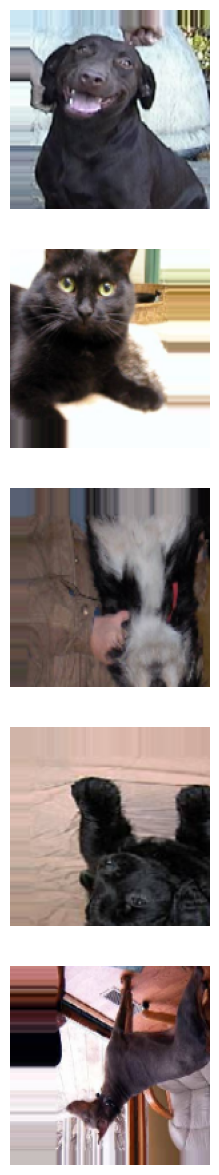

In [21]:
# Create an ImageDataGenerator for the training data with augmentation.
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,                   # Number of images per batch
    directory=train_dir,                     # Directory where the training images are stored
    target_size=(IMG_HEIGHT, IMG_WIDTH),     # Resize all images to this target size
    class_mode='binary'                      # Use binary class labels (cats and dogs)
)

# Get a batch of augmented images. This will fetch the first batch of 128 images (since batch_size is set to 128)
# and from it, we select the first 5 images.
augmented_images = [train_data_gen[0][0][i] for i in range(5)]

# Visualize the first 5 augmented images using the plotImages function
plotImages(augmented_images)


In [22]:
# Create a Sequential model to stack layers.
model = Sequential()

# Add a 2D convolutional layer with 32 filters, each of size (3x3), using ReLU activation.
# The input shape is (150, 150, 3), corresponding to the height, width, and 3 color channels (RGB).
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))

# Add a max pooling layer to reduce the spatial dimensions of the feature map.
model.add(MaxPooling2D((2, 2)))

# Add another convolutional layer with 64 filters and (3x3) kernel size.
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another max pooling layer to downsample the feature map.
model.add(MaxPooling2D((2, 2)))

# Add a third convolutional layer with 128 filters and (3x3) kernel size.
model.add(Conv2D(128, (3, 3), activation='relu'))

# Add another max pooling layer to reduce the size of the feature map.
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the convolutional layers so it can be passed to the fully connected layers.
model.add(Flatten())

# Add a dense layer with 64 units and ReLU activation.
model.add(Dense(64, activation='relu'))

# Output layer with 2 units (binary classification: cat vs dog), using softmax activation.
model.add(Dense(2, activation='softmax'))

# Compile the model with Adam optimizer and sparse categorical crossentropy as the loss function.
# Since we have 2 output classes (cats and dogs), we use 'sparse_categorical_crossentropy'
# and not 'binary_crossentropy'.
model.compile(optimizer='adam', metrics=['accuracy'], loss=SparseCategoricalCrossentropy(from_logits=False))

# Print the model summary to visualize the architecture.
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       2,367,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,460,930 (9.39 MB)

 Trainable params: 2,460,930 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Calculate the total number of batches (images in a batch) for training and validation datasets
# Use floor division (//) to get the number of full batches that can be made from the total images in each dataset.

# Total number of batches for training data
train_batches = total_train // batch_size

# Total number of batches for validation data
val_batches = total_val // batch_size

# Display the results:
# - Total batches for training and validation
# - Total number of images in training and validation datasets
# - The batch size used for training
(train_batches, val_batches, total_train, total_val, batch_size)


(15, 7, 2001, 1001, 128)

In [24]:
history = model.fit(
    train_data_gen,                      # The generator for the training data
    steps_per_epoch=total_train // batch_size,  # Number of batches per epoch for training
    epochs=epochs,                        # Number of times the entire dataset will be passed through the model
    validation_data=val_data_gen,         # The generator for the validation data
    validation_steps=total_val // batch_size,  # Number of batches per epoch for validation
    verbose=1                             # Displays training progress (1 = progress bar, 0 = silent, 2 = one line per epoch)
)


Epoch 1/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 118s 7s/step - accuracy: 0.5042 - loss: 0.9242 - val_accuracy: 0.5011 - val_loss: 0.6935
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.4922 - loss: 0.6963 - val_accuracy: 0.4904 - val_loss: 0.6934
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 132s 7s/step - accuracy: 0.5110 - loss: 0.6905 - val_accuracy: 0.5525 - val_loss: 0.6874
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.5391 - loss: 0.6883 - val_accuracy: 0.4904 - val_loss: 0.6849
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 114s 7s/step - accuracy: 0.5278 - loss: 0.6906 - val_accuracy: 0.5011 - val_loss: 0.6801
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5391 - loss: 0.6779 - val_accuracy: 0.4808 - val_loss: 0.6833
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 114s 7s/step - accuracy: 0.5322 - loss: 0.6870 - val_accuracy: 0.5859 - val_loss: 0.6735
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.5938 - loss: 0.6819 - val_accuracy: 0.5769 - va

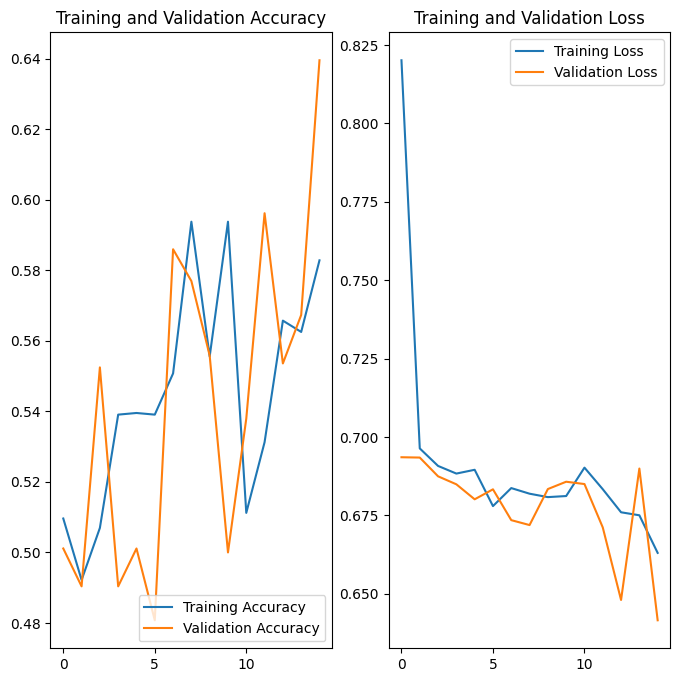

In [25]:
# Extract accuracy and loss values from the history object
acc = history.history['accuracy']           # Training accuracy
val_acc = history.history['val_accuracy']   # Validation accuracy

loss = history.history['loss']               # Training loss
val_loss = history.history['val_loss']       # Validation loss

# Define the range for the epochs (used as x-axis for the plots)
epochs_range = range(epochs)

# Create a figure for the plots
plt.figure(figsize=(8, 8))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)   # 1 row, 2 columns, 1st subplot
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')        # Show legend at the bottom right
plt.title('Training and Validation Accuracy')  # Title for accuracy plot

# Plot training and validation loss
plt.subplot(1, 2, 2)   # 1 row, 2 columns, 2nd subplot
plt.plot(epochs_range, loss, label='Training Loss')        # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
plt.legend(loc='upper right')         # Show legend at the top right
plt.title('Training and Validation Loss')  # Title for loss plot

# Display the plots
plt.show()


In [30]:
# List of correct answers (1 = dog, 0 = cat) for the test images
answers = [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
           1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
           1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
           1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
           0, 0, 0, 0, 0, 0]

# Counter for the number of correct predictions
correct = 0

# Loop through each prediction and compare it to the correct answer
for probability, answer in zip(probabilities, answers):
    # Round the probability to the nearest integer (0 or 1) and compare it to the answer
    if round(probability) == answer:
        correct += 1

# Calculate the percentage of correct predictions
percentage_identified = (correct / len(answers)) * 100

# Check if the model passed the challenge (at least 63% accuracy)
passed_challenge = percentage_identified >= 63

# Print the result
print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
    print("You passed the challenge!")
else:
    print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")


Your model correctly identified 68.0% of the images of cats and dogs.
You passed the challenge!


In [32]:
# Step 1: Clone your GitHub repository (if not done already)
!git clone https://github.com/amittannagit/Cat-and-Dog-Image-Classifier.git
%cd /content/Cat-and-Dog-Image-Classifier/

# Step 2: Create a new branch
!git checkout -b new-branch

# Step 3: Add files that you want to commit (change paths if necessary)
!cp /content/your_notebook_file.ipynb /content/Cat-and-Dog-Image-Classifier/

# Step 4: Check the status to see untracked files
!git status

# Step 5: Stage the files for commit
!git add .

# Step 6: Commit your changes
!git commit -m "Add work for new-branch"

# Step 7: Push your branch to GitHub
!git push origin new-branch


Cloning into 'Cat-and-Dog-Image-Classifier'...
/content/Cat-and-Dog-Image-Classifier
Switched to a new branch 'new-branch'
cp: cannot stat '/content/your_notebook_file.ipynb': No such file or directory
On branch new-branch

No commits yet

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	Cat-and-Dog-Image-Classifier/

nothing added to commit but untracked files present (use "git add" to track)
error: 'Cat-and-Dog-Image-Classifier/' does not have a commit checked out
fatal: adding files failed
Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@a143e22ca707.(none)')
error: src refspec new-branch does not match any
error: failed to push some refs to 'https://github.com/amittannagit/Cat-and-Dog-Imag